# Import stocks price data from Finnhub


In [133]:
import finnhub
import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored as cl 


# Setup client with my personal api_key (see https://finnhub.io/)
finnhub_client = finnhub.Client(api_key="put_your_api_key_here")

# Data from saturday 1 January 2000 00:00:00 = 946684800 UNIX timestamp
#       to   wednesday 27 July 2022 06:43:50  = 1658904230 UNIX timestamp
#       1577833200 = 2020 /01/01 hr 00.00.00
data = finnhub_client.crypto_candles('COINBASE:BTC-EUR', '60', 1577833200, 1658904230)
# Convert to Pandas Dataframe
data = pd.DataFrame(data)
# Rename columns
data = data.rename(columns={"c": "close", "h": "high", "l": "low", "o": "open", "s": "status", "t": "date", "v": "volume"})

print("Shape of data", data.shape)
data.head()

Shape of data (22538, 7)


,close,high,low,open,status,date,volume
0,6446.24,6464.45,6430.01,6451.16,ok,1577473200,25.496672
1,6455.37,6465.20,6441.15,6441.15,ok,1577476800,23.635273
2,6466.34,6466.66,6448.76,6455.33,ok,1577480400,30.044130
3,6477.50,6489.97,6458.70,6465.67,ok,1577484000,22.646133
4,6493.17,6493.91,6470.00,6472.03,ok,1577487600,13.351325


In [134]:
# Remove rows with status no_data
data = data[data['status'] == 'ok']
# Remove status column
data = data.drop(['status'], axis='columns')
# Convert UNIX timestamp to date 
#     For form y-m-d -h-m-mil -> datetime.datetime.fromtimestamp
#     For form y-m-d -> datetime.date.fromtimestamp 
data['date'] = data['date'].apply(datetime.datetime.fromtimestamp, 'columns') 
# Convert to datetime pandas
data['date'] = pd.to_datetime(data['date'])
# set index datetime
data = data.set_index('date')

print("Shape of data", data.shape)
data.head()

Shape of data (22538, 5)


,close,high,low,open,volume
date,,,,,
2019-12-27 20:00:00,6446.24,6464.45,6430.01,6451.16,25.496672
2019-12-27 21:00:00,6455.37,6465.20,6441.15,6441.15,23.635273
2019-12-27 22:00:00,6466.34,6466.66,6448.76,6455.33,30.044130
2019-12-27 23:00:00,6477.50,6489.97,6458.70,6465.67,22.646133
2019-12-28 00:00:00,6493.17,6493.91,6470.00,6472.03,13.351325


In [135]:
# read btc usd hourly data
data_btc = pd.read_csv("./Data_Crypto/btc-usd-hourly.csv", index_col='time')
data_btc.index = pd.to_datetime(data_btc.index)
data_btc.index = data_btc.index.tz_convert(None)
print("Shape of external data", data_btc.shape)
data_btc.head()

Shape of external data (40845, 5)


,open,high,low,close,volume
time,,,,,
2015-08-01 01:00:00,285.25,285.25,283.10,283.10,210.412214
2015-08-01 02:00:00,283.10,283.61,282.25,283.06,203.883734
2015-08-01 03:00:00,283.27,283.85,283.00,283.66,124.134100
2015-08-01 04:00:00,283.67,284.00,283.43,283.60,153.696900
2015-08-01 05:00:00,283.66,283.66,282.33,282.34,122.428521


In [136]:
## Union two dataframes and remove duplicates
to_remove = data.join(data_btc, how='inner', rsuffix='remove_')
data = pd.concat([data_btc, data.drop(to_remove.index)], axis=0)
print("Shape of final data", data.shape)
data = data.sort_index()
data.head()

Shape of final data (60744, 5)


,open,high,low,close,volume
2015-08-01 01:00:00,285.25,285.25,283.10,283.10,210.412214
2015-08-01 02:00:00,283.10,283.61,282.25,283.06,203.883734
2015-08-01 03:00:00,283.27,283.85,283.00,283.66,124.134100
2015-08-01 04:00:00,283.67,284.00,283.43,283.60,153.696900
2015-08-01 05:00:00,283.66,283.66,282.33,282.34,122.428521


# Donchian Channel Breakout Trading Strategy

In [137]:
# Etxracting numerical features
data["dayofweek"] = data.index.dayofweek
data["day"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year
data["dayofyear"] = data.index.dayofyear
data["quarter"] = data.index.quarter

data.head()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter
2015-08-01 01:00:00,285.25,285.25,283.10,283.10,210.412214,5,1,8,2015,213,3
2015-08-01 02:00:00,283.10,283.61,282.25,283.06,203.883734,5,1,8,2015,213,3
2015-08-01 03:00:00,283.27,283.85,283.00,283.66,124.134100,5,1,8,2015,213,3
2015-08-01 04:00:00,283.67,284.00,283.43,283.60,153.696900,5,1,8,2015,213,3
2015-08-01 05:00:00,283.66,283.66,282.33,282.34,122.428521,5,1,8,2015,213,3


In [138]:
# Donchian Channel calculation considering 3 and 2 rolling time
data["hhv24"] = data.high.rolling(24).max() # maximum of the last 3 values (including current value)
data["llv24"] = data.low.rolling(24).min() # minimum of the last 3 values (including current value)
data["hhv10"] = data.high.rolling(10).max() # maximum of the last 2 values (including current value)
data["llv10"] = data.low.rolling(10).min() # minimum of the last 2 values (including current value)
data.dropna(inplace=True)

# save to csv
file_name = "./Data_Crypto/dataCRYPTODC.csv"
data.to_csv(file_name, index=True)

data.head()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter,hhv24,llv24,hhv10,llv10
2015-08-02 00:00:00,281.53,281.63,279.74,279.75,178.145831,6,2,8,2015,214,3,285.25,277.26,282.83,277.26
2015-08-02 01:00:00,279.75,279.75,278.18,278.63,159.628930,6,2,8,2015,214,3,284.00,277.26,282.83,278.18
2015-08-02 02:00:00,278.66,280.73,278.65,280.56,124.514165,6,2,8,2015,214,3,284.00,277.26,282.83,278.18
2015-08-02 03:00:00,280.32,280.90,279.62,279.84,109.934748,6,2,8,2015,214,3,284.00,277.26,282.83,278.18
2015-08-02 04:00:00,279.90,280.31,278.19,278.65,159.883300,6,2,8,2015,214,3,283.66,277.26,282.83,278.18


In [139]:
# True when:
# array1 crosses array2 from below to above
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

# True when:
# array1 crosses array2 from above to below
def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))

# When the daily close crosses the 3-period Donchian Channel High (hhv3),
# we will buy a number of BITCOIN shares
enter_rules = crossover(data.close, data.hhv24.shift(1))  # 24-period Donchian High
exit_rules = crossunder(data.close, data.llv10.shift(1)) | (data.day < data.day.shift(1))  # 10-period Donchian Low

print("Exit rules: \n", exit_rules.head())
print("")
print("Enter rules: \n", enter_rules.tail())

Exit rules: 
 2015-08-02 00:00:00    False
2015-08-02 01:00:00    False
2015-08-02 02:00:00    False
2015-08-02 03:00:00    False
2015-08-02 04:00:00    False
dtype: bool

Enter rules: 
 2022-07-27 04:00:00    False
2022-07-27 05:00:00    False
2022-07-27 06:00:00    False
2022-07-27 07:00:00    False
2022-07-27 08:00:00    False
dtype: bool


In [140]:
def marketposition_generator(service_dataframe, enter_rules, exit_rules):    
    # mp = market position, equals 1 when trading, 0 otherwise
    # status=1 trading status
    # status=0 otherwise
    status = 0 
    mp = [] # list of market positions
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:  # BUY RULE 
            if (i == 1 and j != -1):
                status = 1
        else:           # SELL RULE
            if j == -1 :
                status = 0
                
        mp.append(status)
    
    service_dataframe['mp'] = mp
    service_dataframe['mp_not_shifted'] = mp
    # Delay by one record as the operation will atually start the next bar
    service_dataframe.mp = service_dataframe.mp.shift(1) 
    return service_dataframe

In [141]:
def apply_trading_system(imported_dataframe, enter_rules, exit_rules):
    
    dataframe = imported_dataframe.copy()
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    # make market positions status (mp)
    dataframe = marketposition_generator(dataframe, dataframe.enter_rules, dataframe.exit_rules)
    # entry price 
    dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & 
                                        (dataframe.mp == 1), dataframe.open, np.nan)
    # number of stokes purchased
    dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & 
                                        (dataframe.mp == 1), OPERATION_MONEY / dataframe.open, np.nan) 
    # fill with entry price
    # ffill=forward-fill propagates the last observed non-null value forward until another non-null value is encountered
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    # fill with stockes purchased
    dataframe["number_of_stocks"] = dataframe["number_of_stocks"].fillna(method='ffill')    
    # open operations=instant trade gain / loss (when mp=1),
    #                 0 otherwise               (when mp=0)
    dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
    # At the exit of the trade: total gain/loss * number of stokes - transaction costs
    dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
            (dataframe.open.shift(-1) - dataframe.entry_price) * dataframe.number_of_stocks - 2 * COSTS,
             dataframe.open_operations) 
    # entry price for plotting
    dataframe["plot_entry_price"] = np.where((dataframe.mp.shift(1) == 0) & 
                                        (dataframe.mp == 1), dataframe.open, np.nan)
    # sell price for plotting
    dataframe["plot_sell_price"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
            dataframe.open.shift(-1), np.nan)
    # Put 0 when not trading  
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0) 
    # operations = trade gain/loss of only all closed trades (support field)
    dataframe["operations"] = np.where((dataframe.mp.shift(-1) == 0) & 
                                       (dataframe.mp == 1), dataframe.open_operations, np.nan)
    # closed_equity = equity line (profit curve) with closed transactions only
    # it does not take into account fluctuations during the trade
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    # open equity = equity line (profit curve) with all trade
    # it does take into account fluctuations during the trade
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    # save to csv
    dataframe.to_csv("./Data_Crypto/trading_system_exportDC.csv", index=True)

    return dataframe

In [142]:
COSTS = 0 # cost of operations
OPERATION_MONEY = 10000 # Operation money for single trade 

# Get trading system
trading_system = apply_trading_system(data, enter_rules, exit_rules)

trading_system.head()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,...,mp,mp_not_shifted,entry_price,number_of_stocks,open_operations,plot_entry_price,plot_sell_price,operations,closed_equity,open_equity
2015-08-02 00:00:00,281.53,281.63,279.74,279.75,178.145831,6,2,8,2015,214,...,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2015-08-02 01:00:00,279.75,279.75,278.18,278.63,159.628930,6,2,8,2015,214,...,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2015-08-02 02:00:00,278.66,280.73,278.65,280.56,124.514165,6,2,8,2015,214,...,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2015-08-02 03:00:00,280.32,280.90,279.62,279.84,109.934748,6,2,8,2015,214,...,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
2015-08-02 04:00:00,279.90,280.31,278.19,278.65,159.883300,6,2,8,2015,214,...,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0


## Some Statistics 

In [143]:
# total number of transactions (including those open)
sum((trading_system.mp == 1) & (trading_system.mp.shift(1) == 0))

781

In [144]:
# total number of operations (only those closed)
sum((trading_system.mp == 1) & (trading_system.mp.shift(-1) == 0))

781

In [145]:
# Final profit
print(round(trading_system.open_equity[-1],2)) # open equity
print(round(trading_system.closed_equity[-1],2)) # closed equity

44499.09
44499.09


In [146]:
# Win-Loss Ratio
def percent_win(operations):
    return round((operations[operations >= 0].count() / operations[operations < 0].count()),2)

print("Win-Loss Ratio: ", percent_win(trading_system.operations.dropna()))

Win-Loss Ratio:  0.71


In [147]:
# Total profit operations
def total_profit_operations(operations):
    return operations[operations > 0].count()

print("Total profit operations : ", total_profit_operations(trading_system.operations.dropna()))

Total profit operations :  324


In [148]:
# Total loss operations
def total_loss_operations(operations):
    return operations[operations < 0].count()

print("Total loss operations: ", total_loss_operations(trading_system.operations.dropna()))

Total loss operations:  457


In [149]:
# Average Profit
def avg_profit(total_profit, num_operations):
    return round( total_profit / num_operations,2)

avg_profit_trading_system = avg_profit( round(trading_system.open_equity[-1],2),
trading_system.operations.dropna().count())
print("Average profit without metalabing: ", avg_profit_trading_system )

Average profit without metalabing:  56.98


In [151]:
# Plot Equity Line
def plot_equity(equity,color):
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return

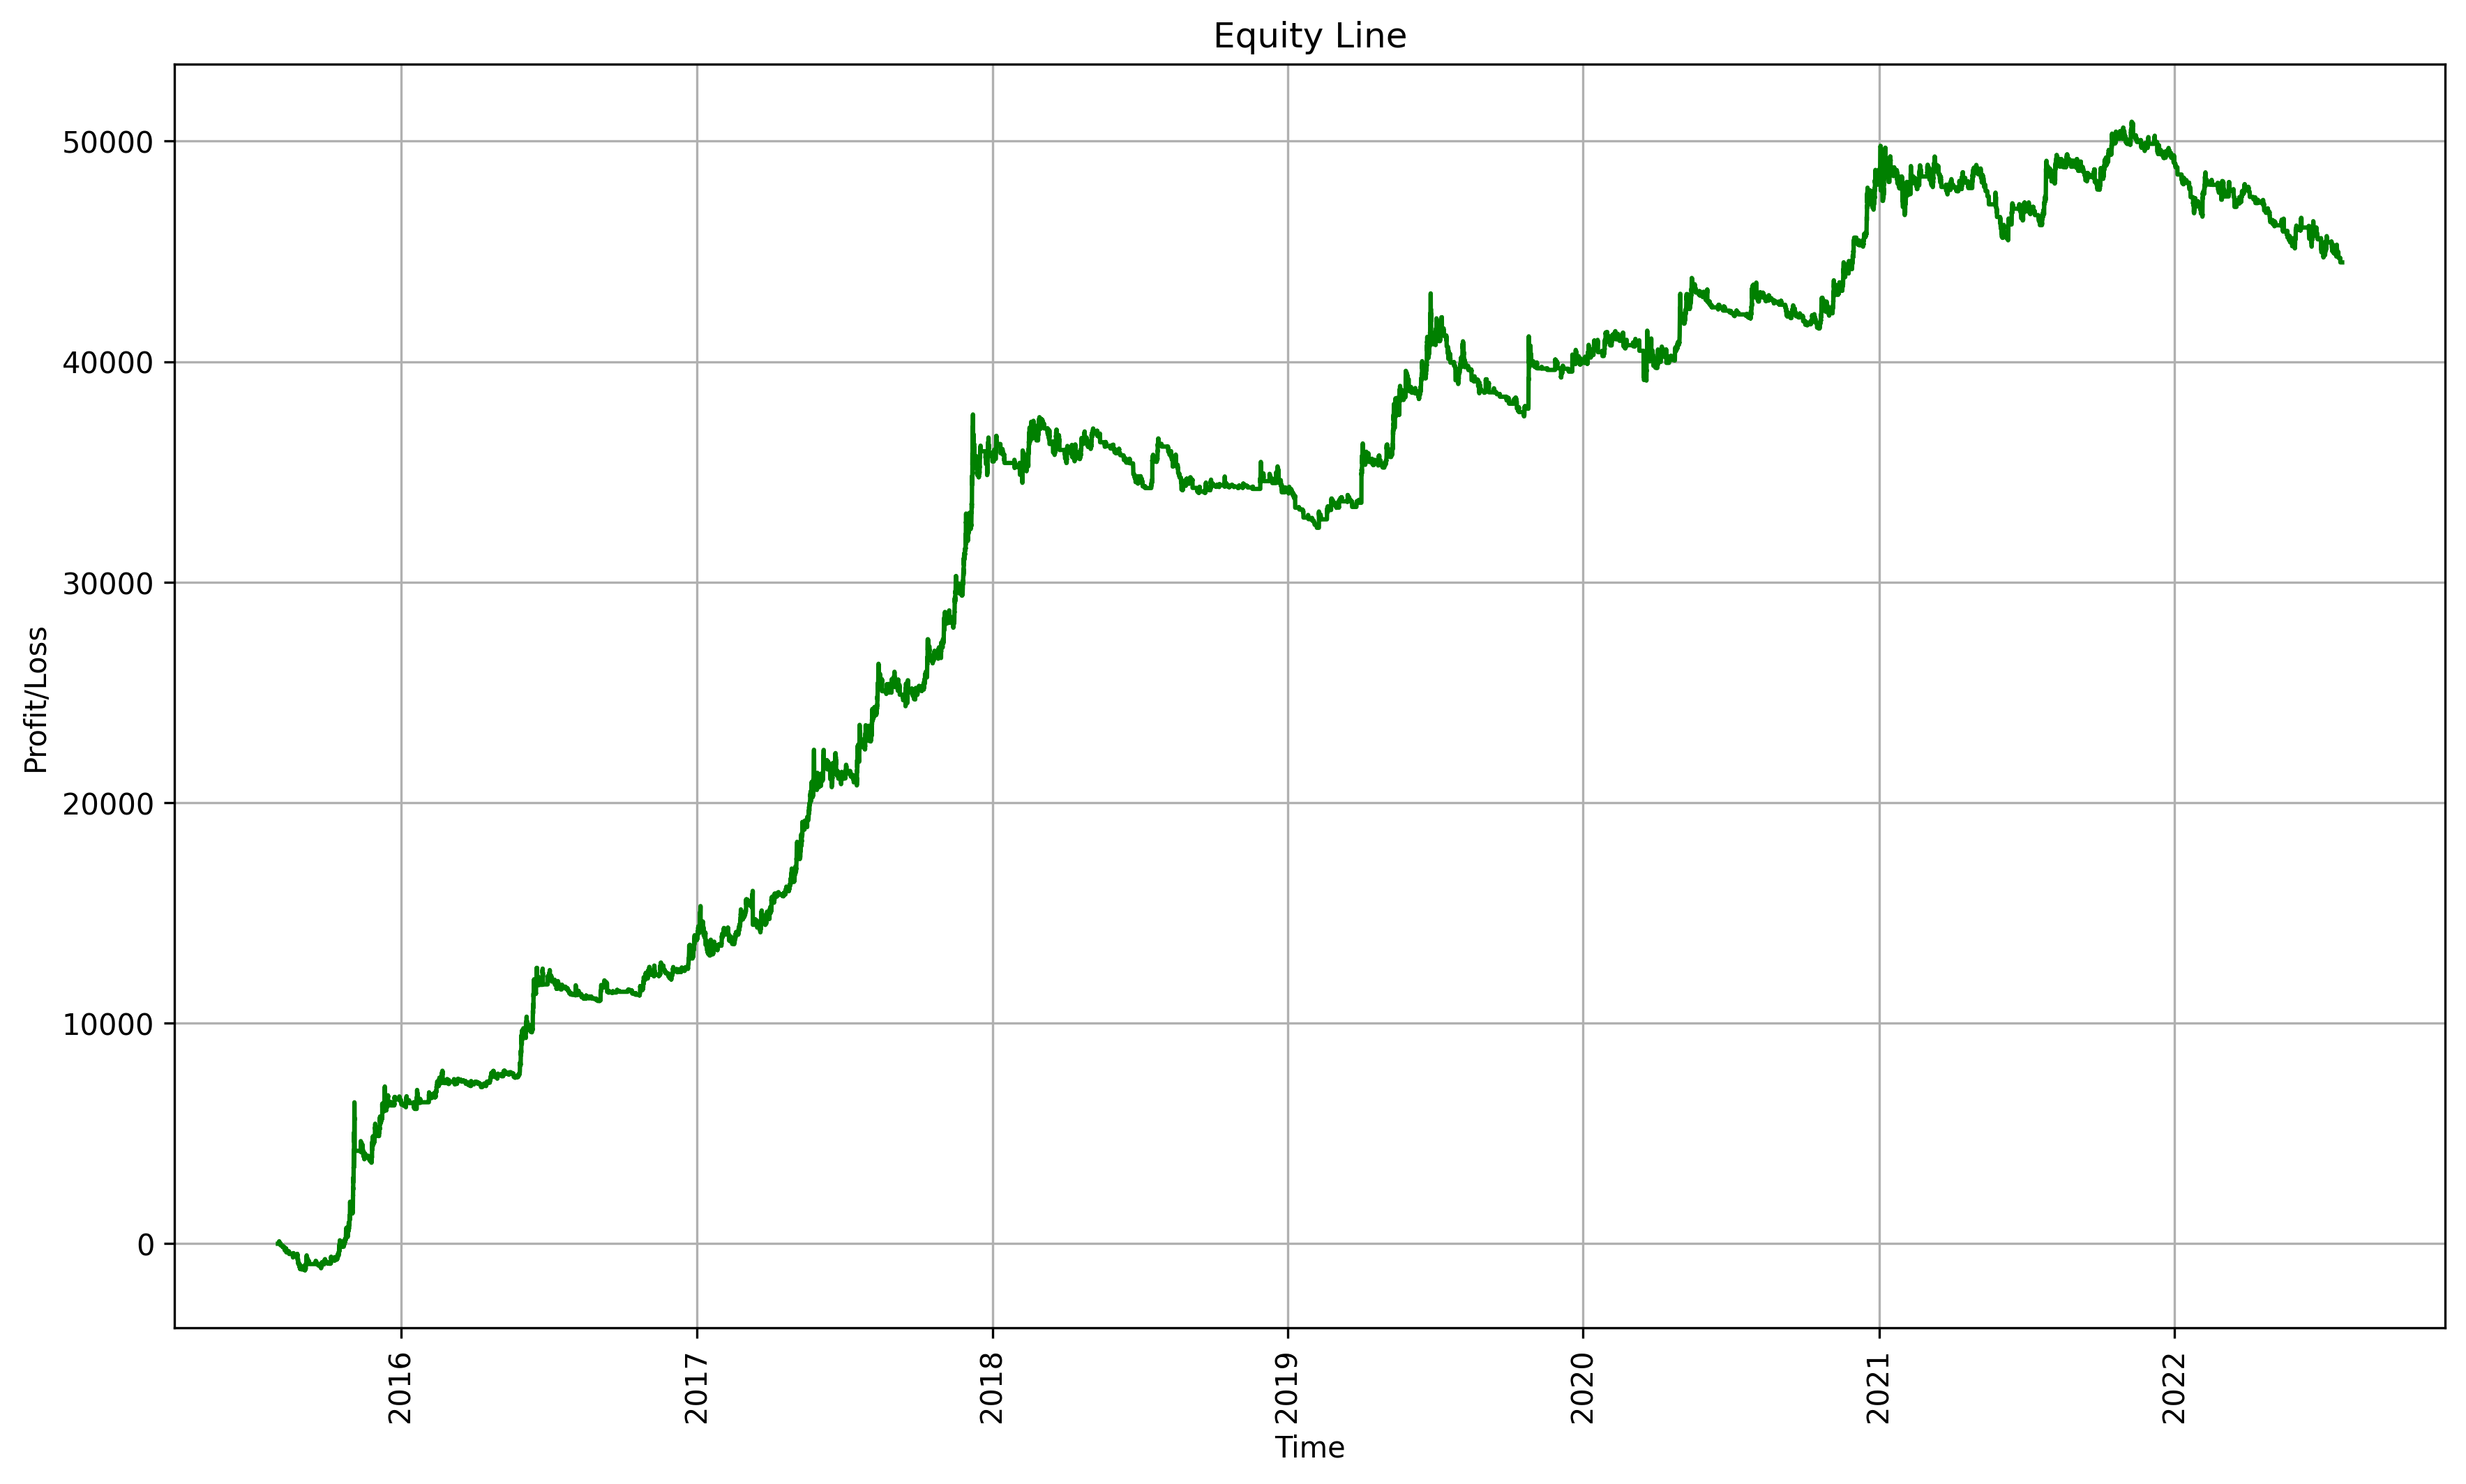

In [152]:
# Plot open equity = equity line with fluctuations during the trade  
plot_equity(trading_system.open_equity,"green");

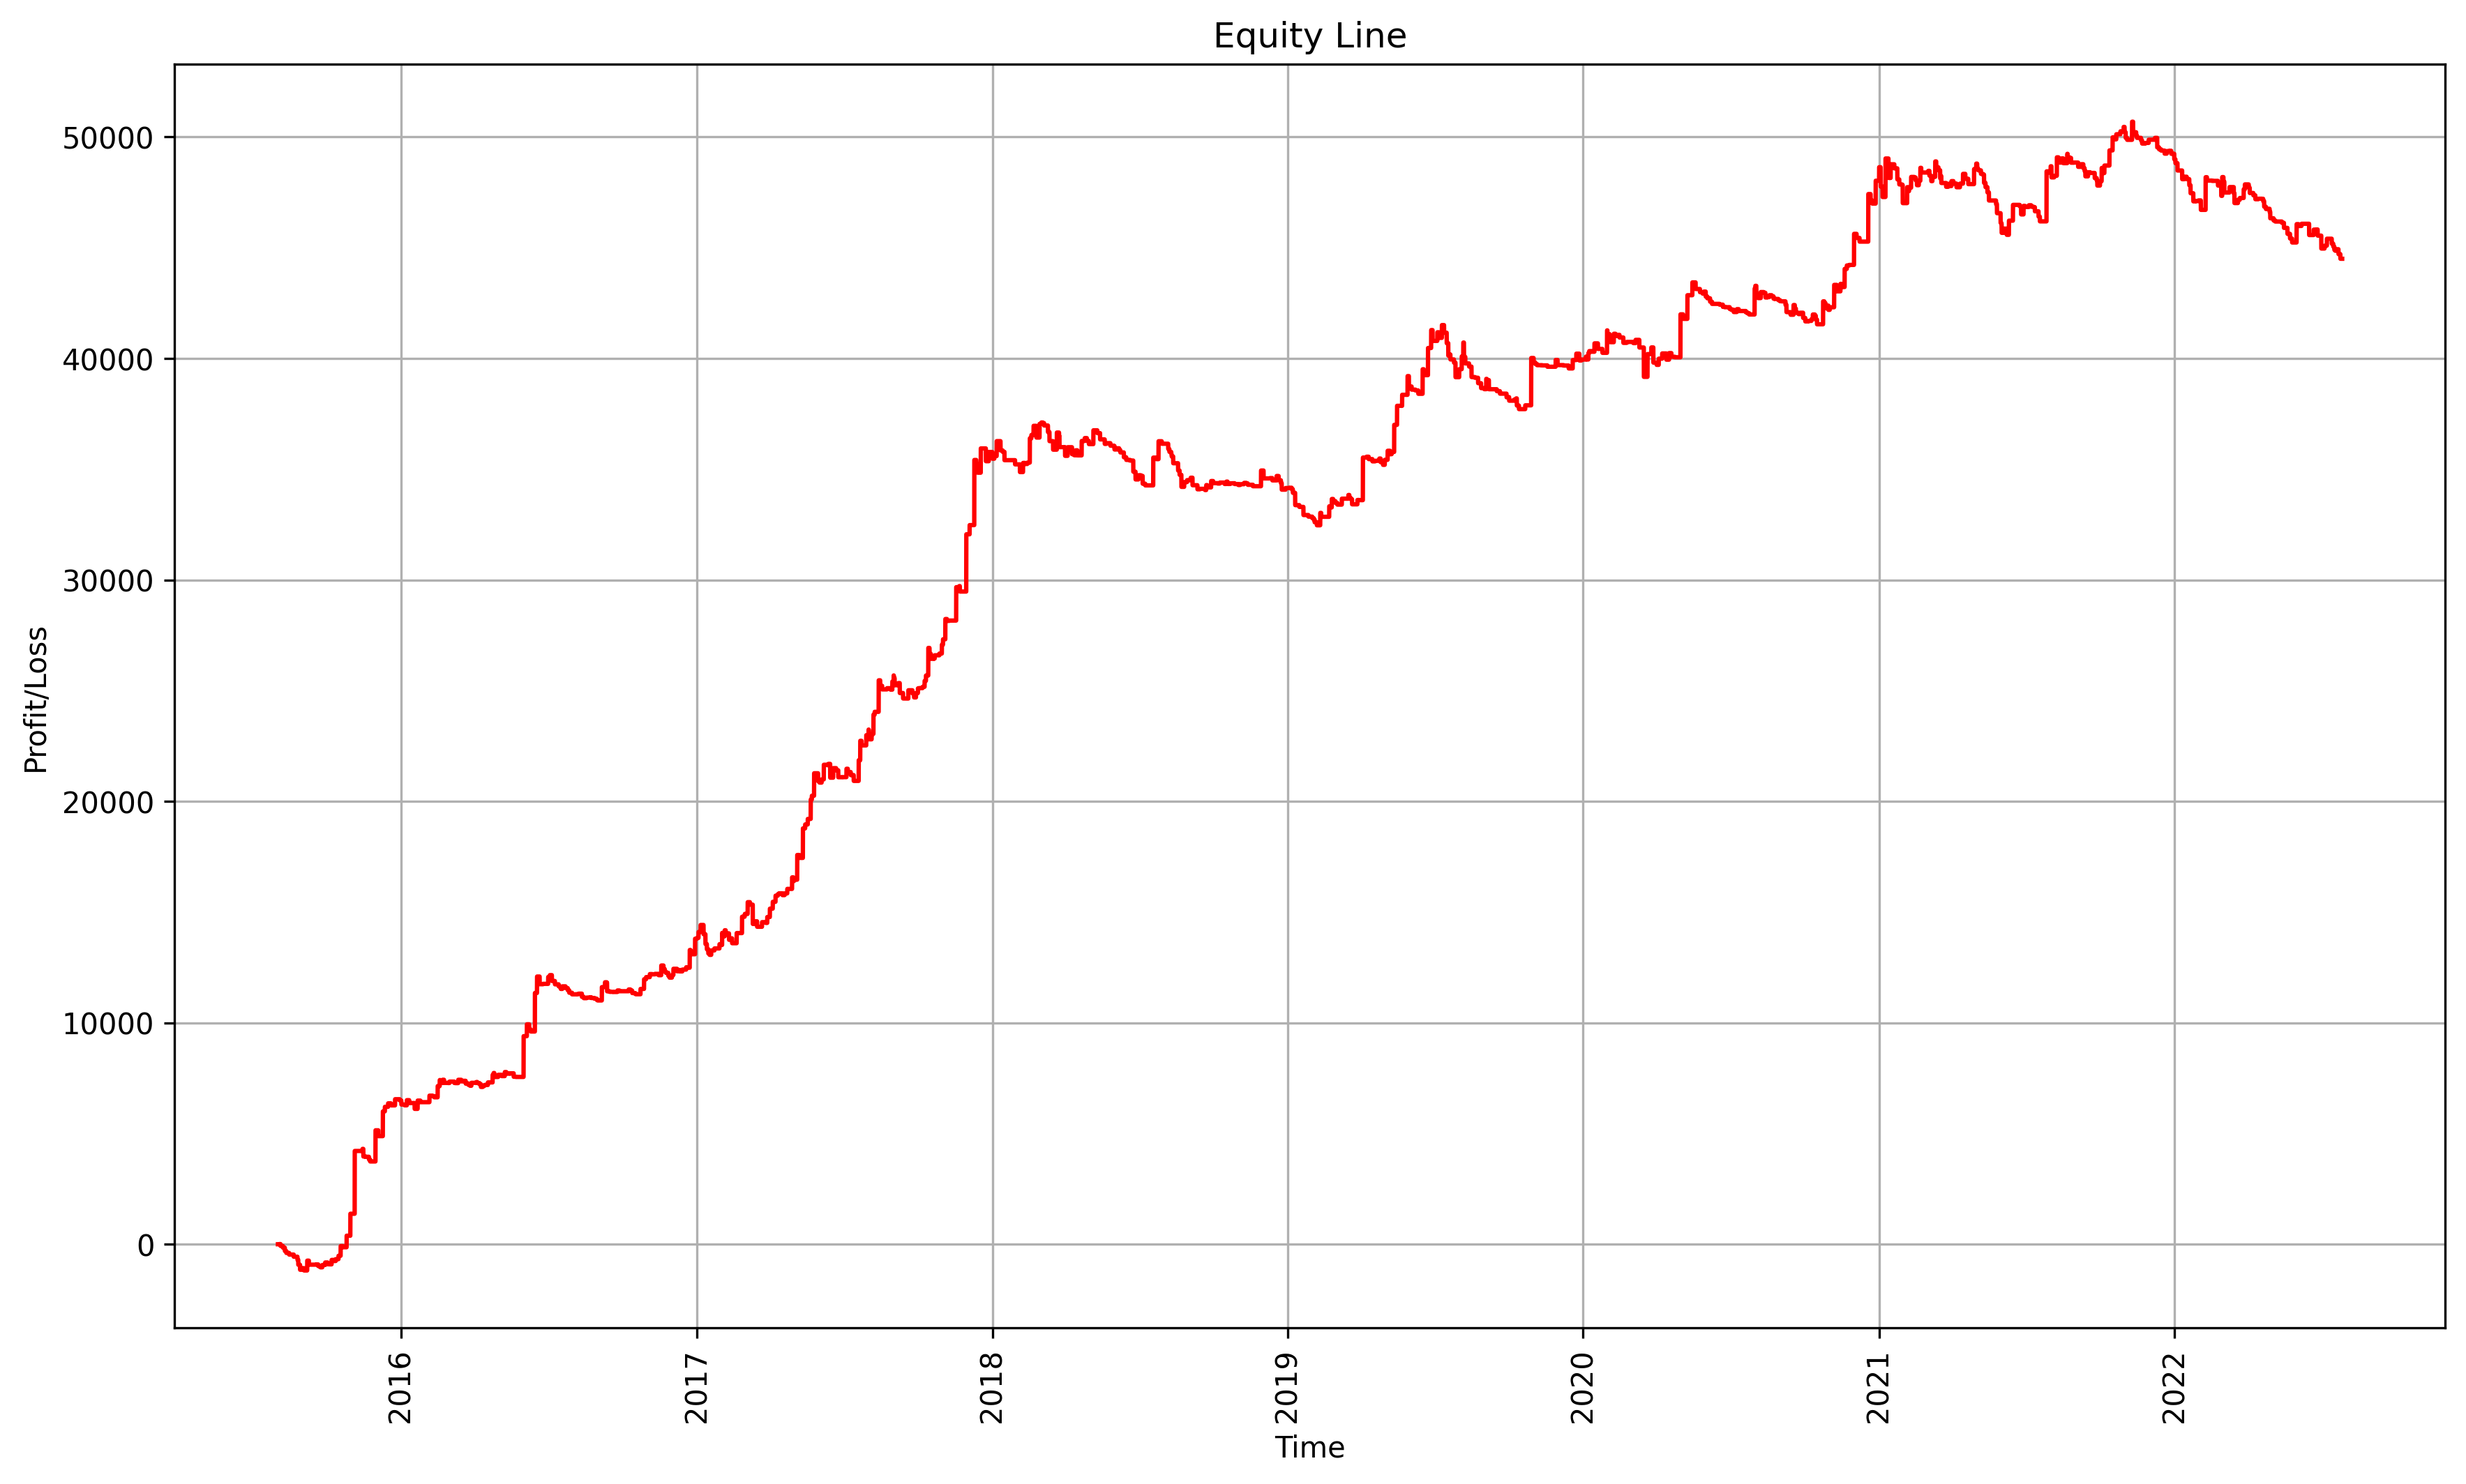

In [153]:
# Plot closed equity = equity line with not fluctuations during the trade
plot_equity(trading_system.closed_equity,"red");

In [154]:
# Drawdown = difference between the highest and lowest peak in a time interval
def drawdown(equity):
    # calculates the drawdown given an equity line
    maxvalue = equity.expanding(0).max() 
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series
# Plot Drawdown
def plot_drawdown(equity,color):
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return

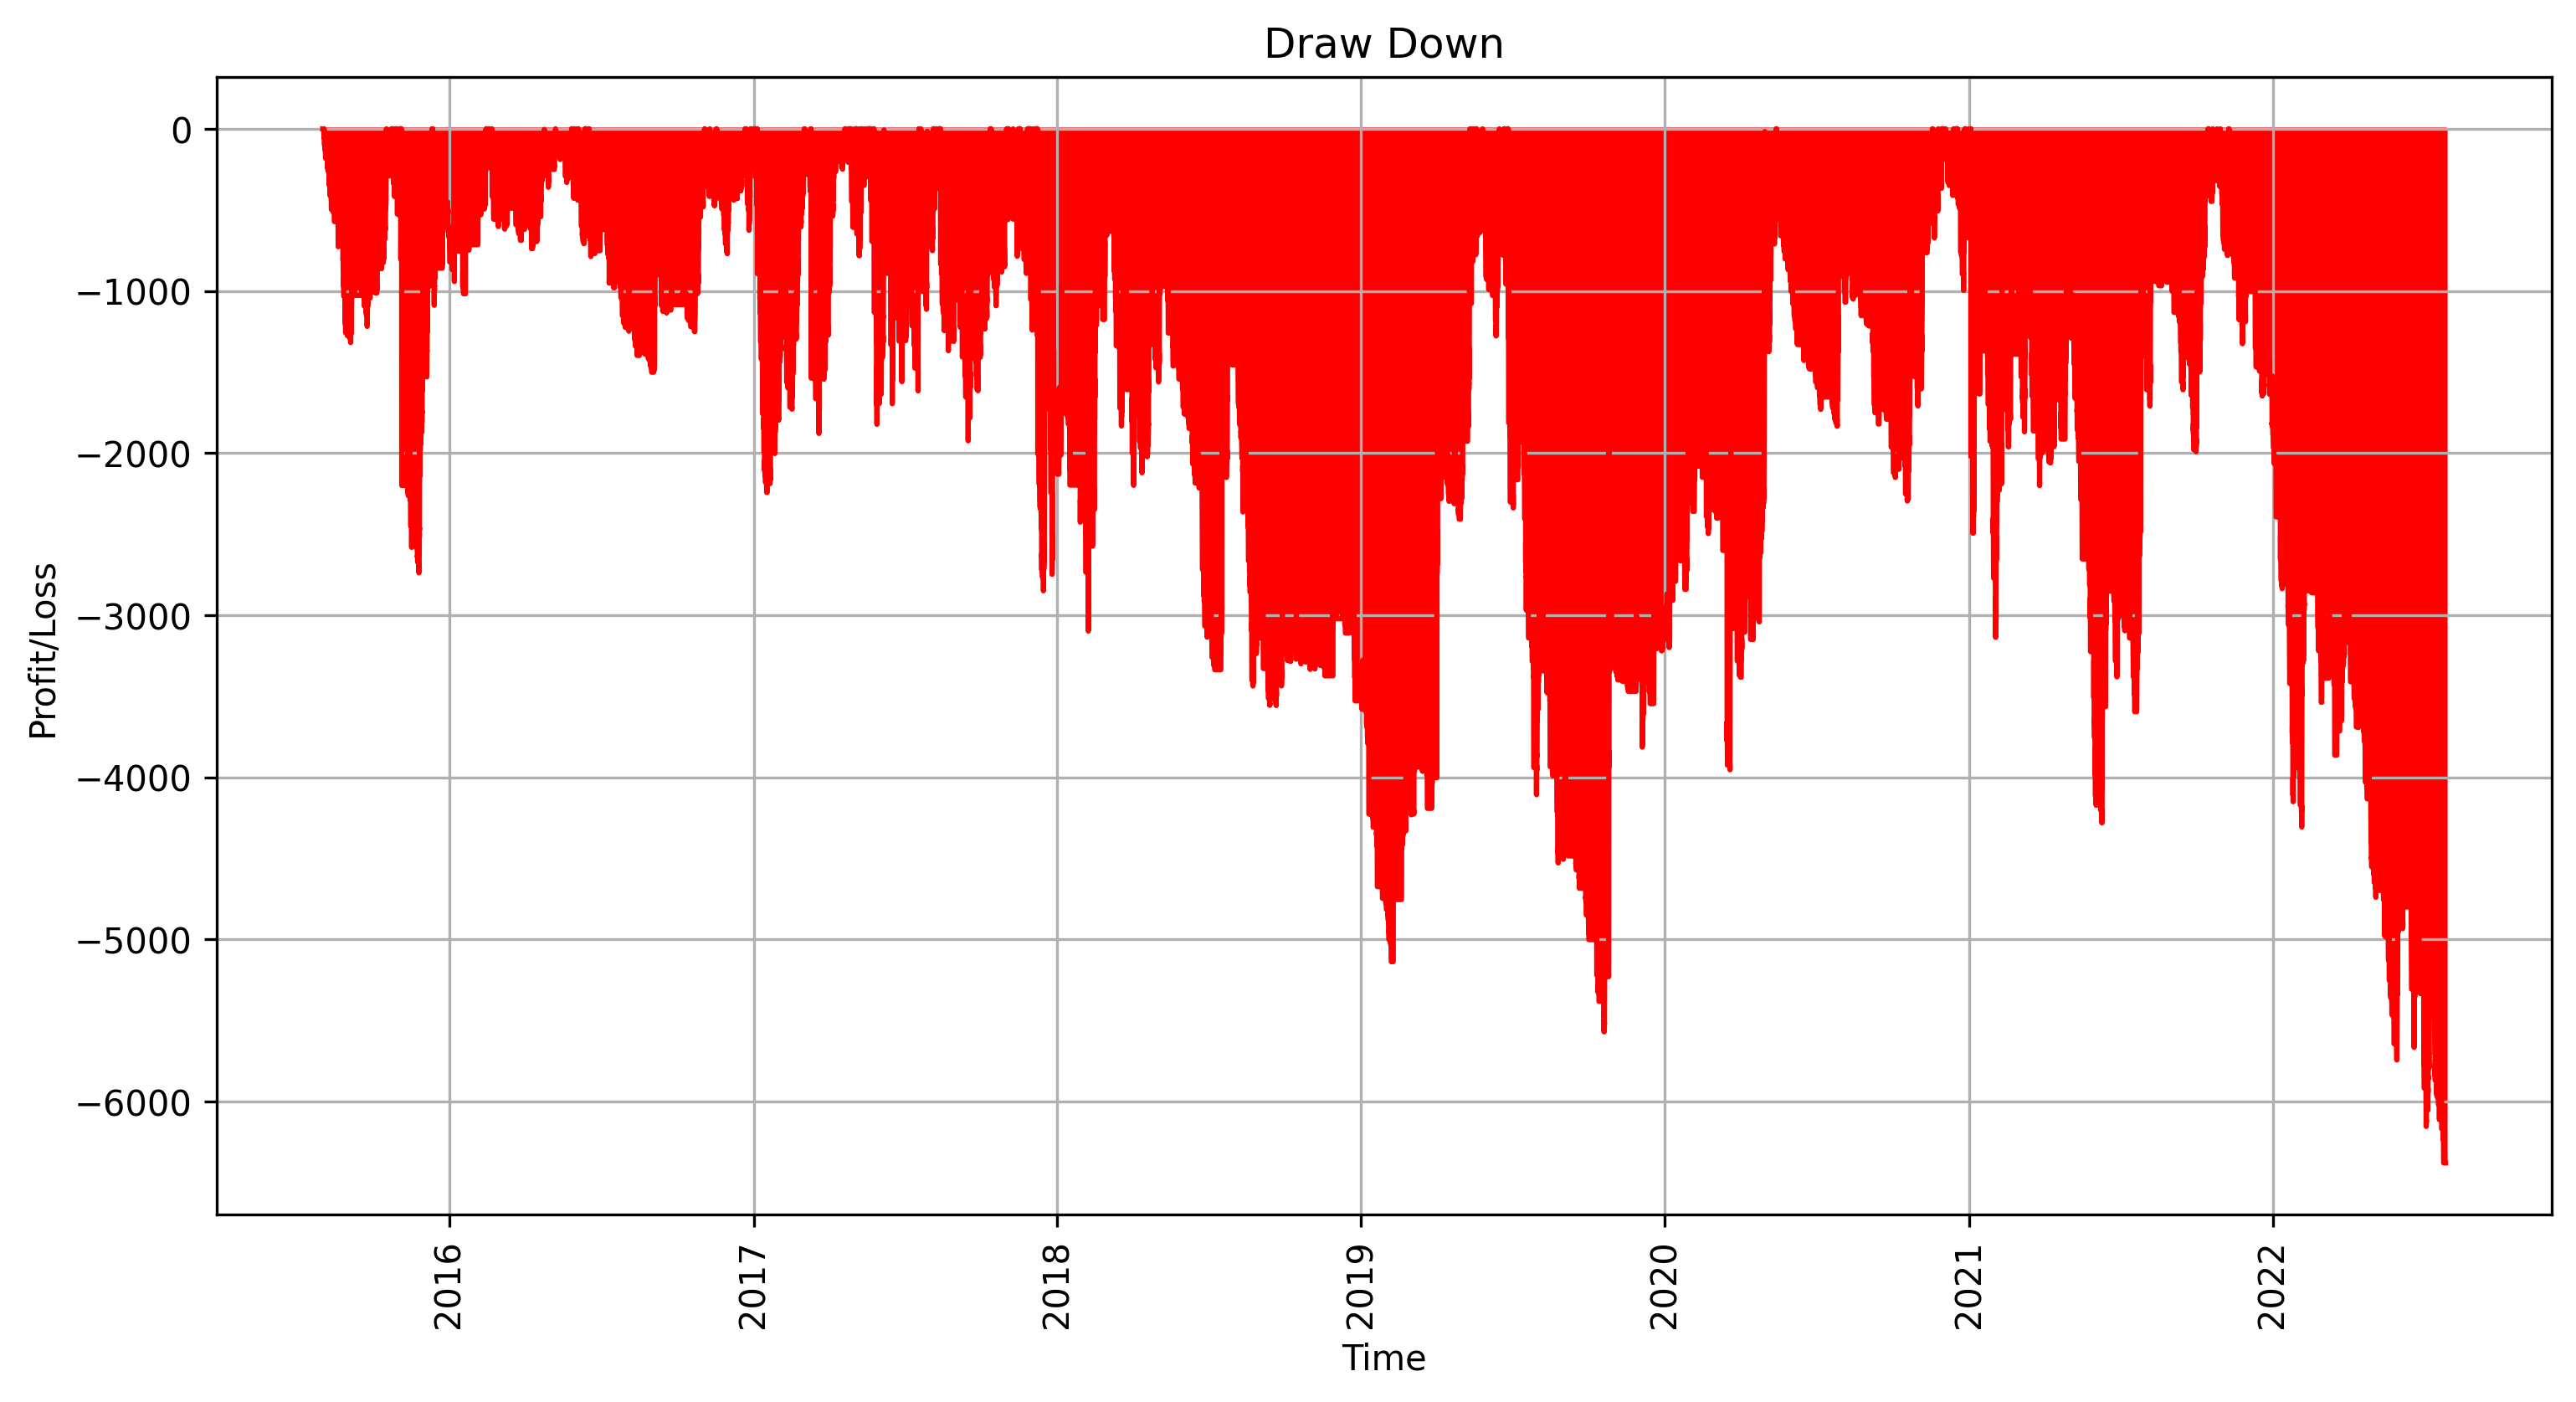

In [155]:
# Plot drawdown open equity
plot_drawdown(trading_system.open_equity,"red")

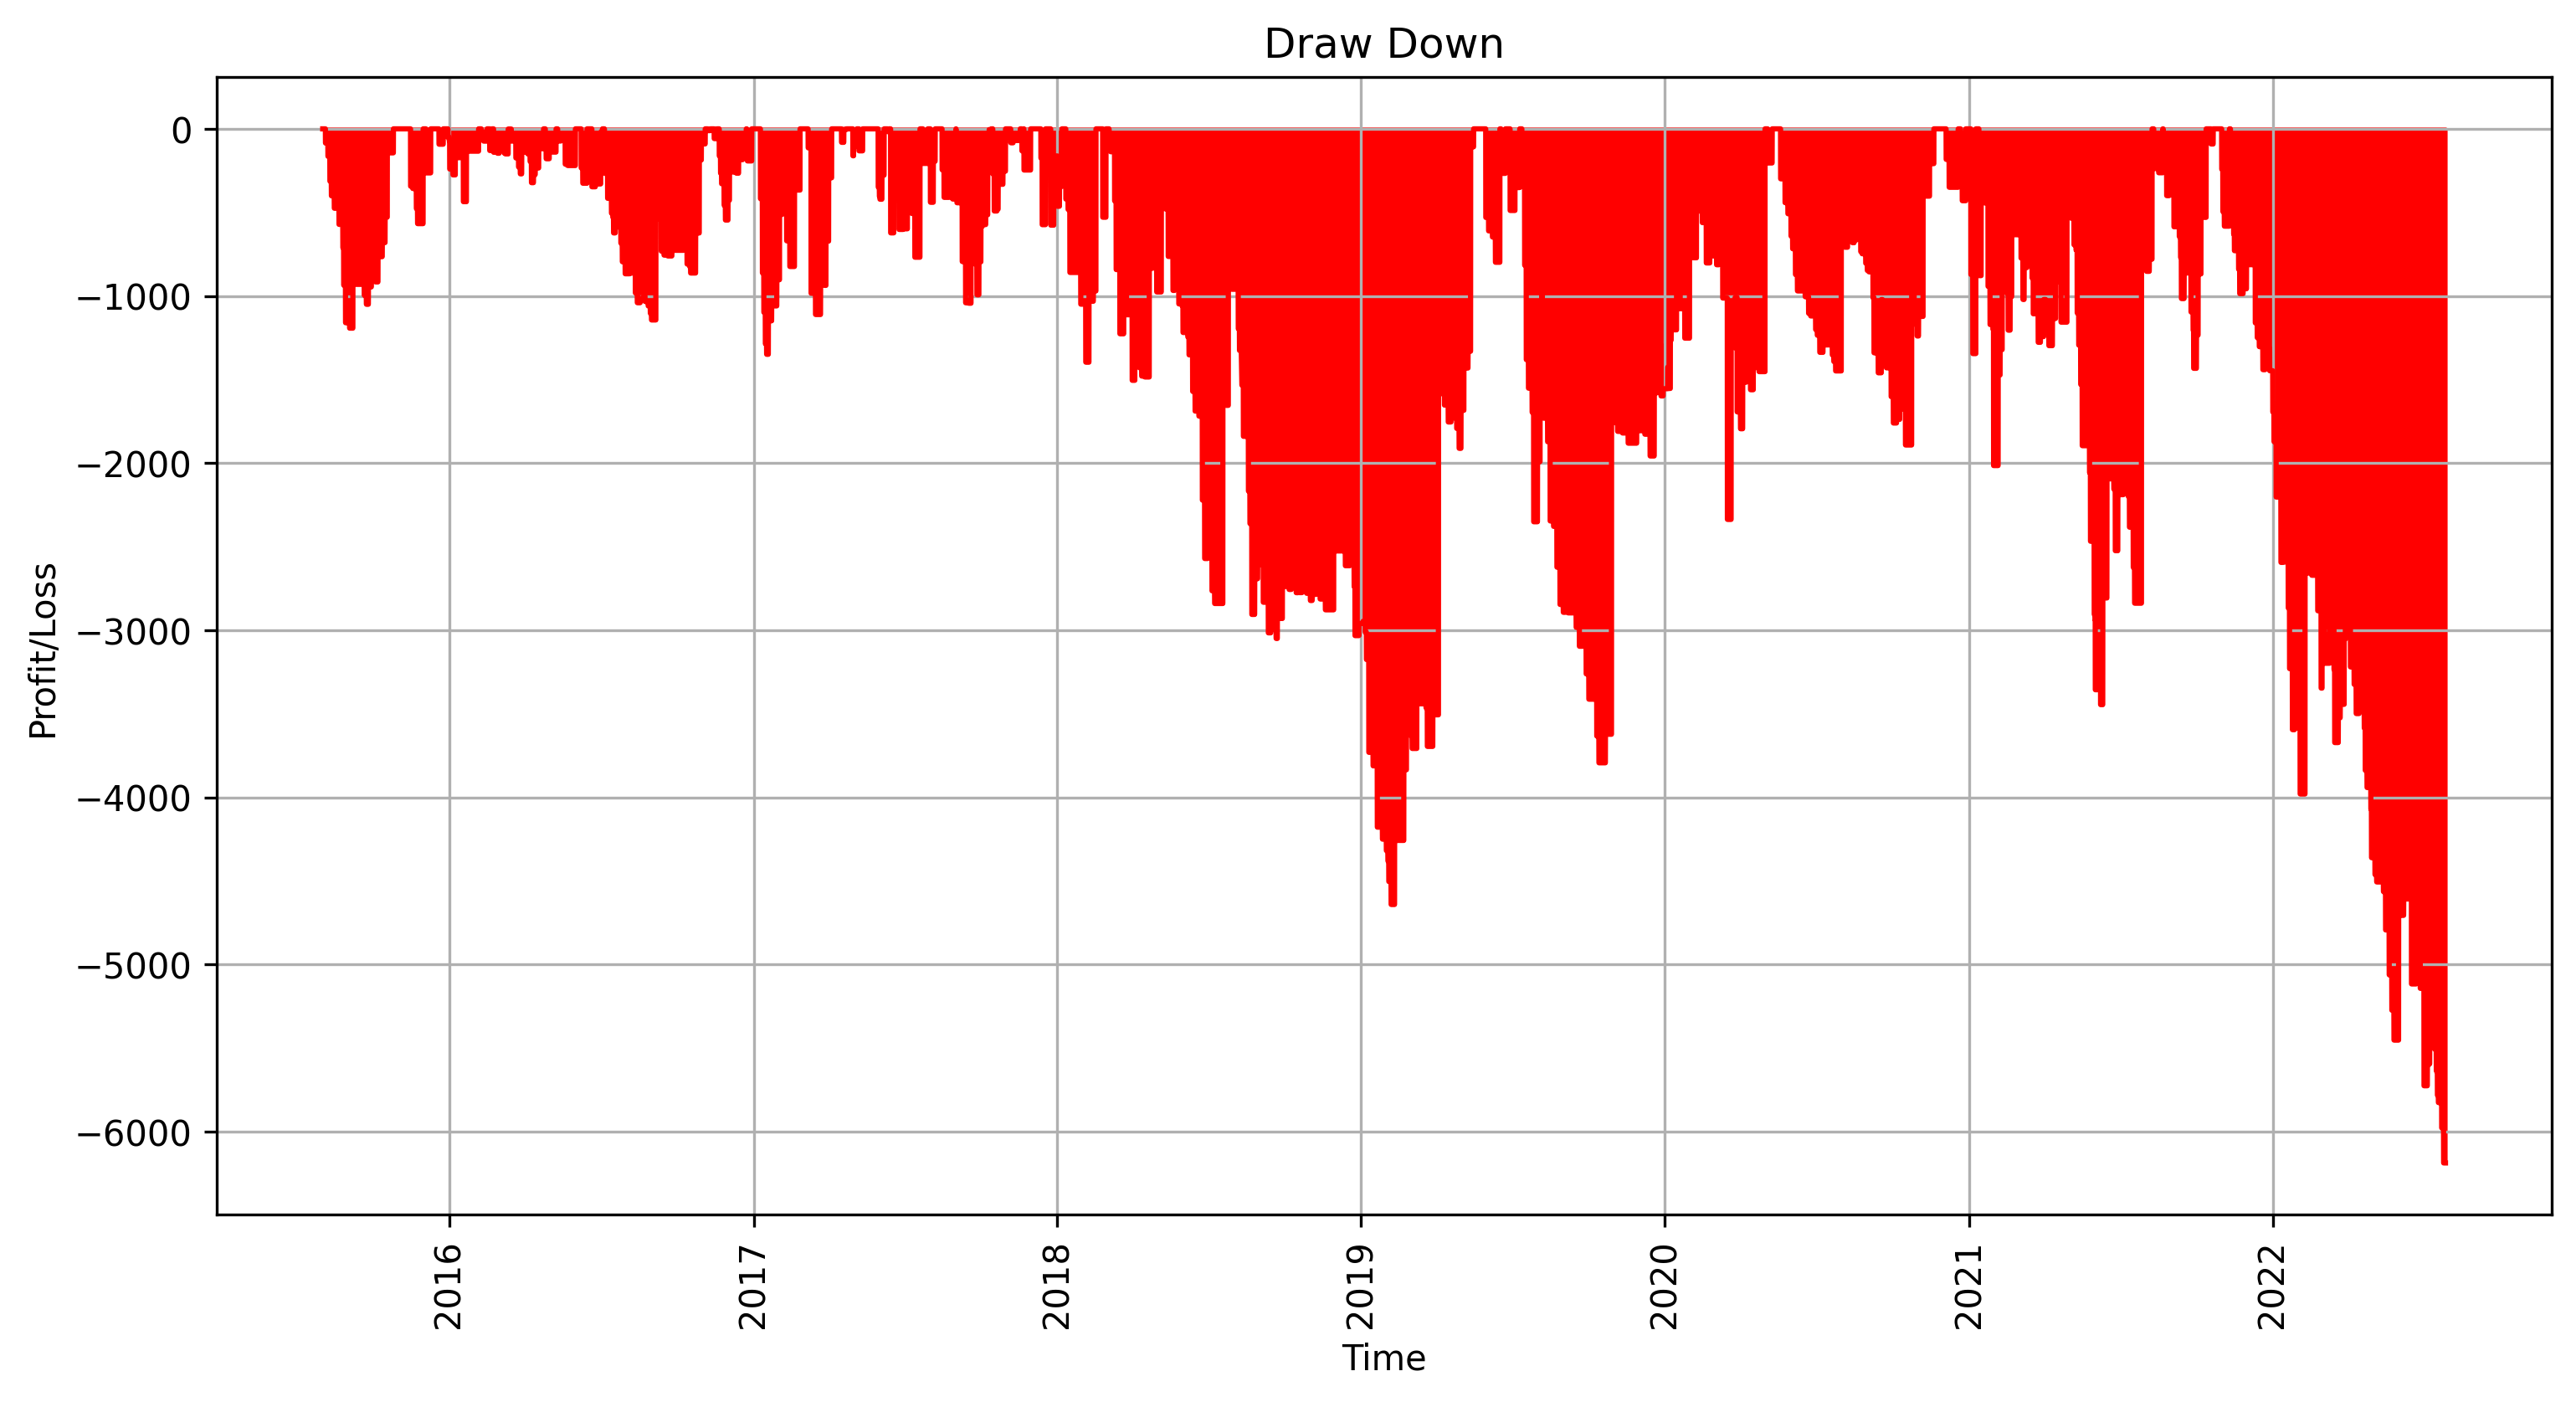

In [156]:
# Plot drawdown closed equity
plot_drawdown(trading_system.closed_equity,"red");

In [157]:
# MAX drawdown
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)

print("Max Dradown: ",max_draw_down(trading_system.open_equity))

Max Dradown:  -6379.16


In [158]:
# Average drawdown
def avgdrawdown_nozero(equity):
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

print("Average Dradown without metalabing: ", avgdrawdown_nozero(trading_system.open_equity))

Average Dradown without metalabing:  -1891.88


In [159]:
# Plot double equity line
def plot_double_equity(closed_equity,open_equity):
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red', label="Open equity")
    plt.plot(closed_equity, color='green', label="Closed equity")
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.legend()
    plt.show()
    return

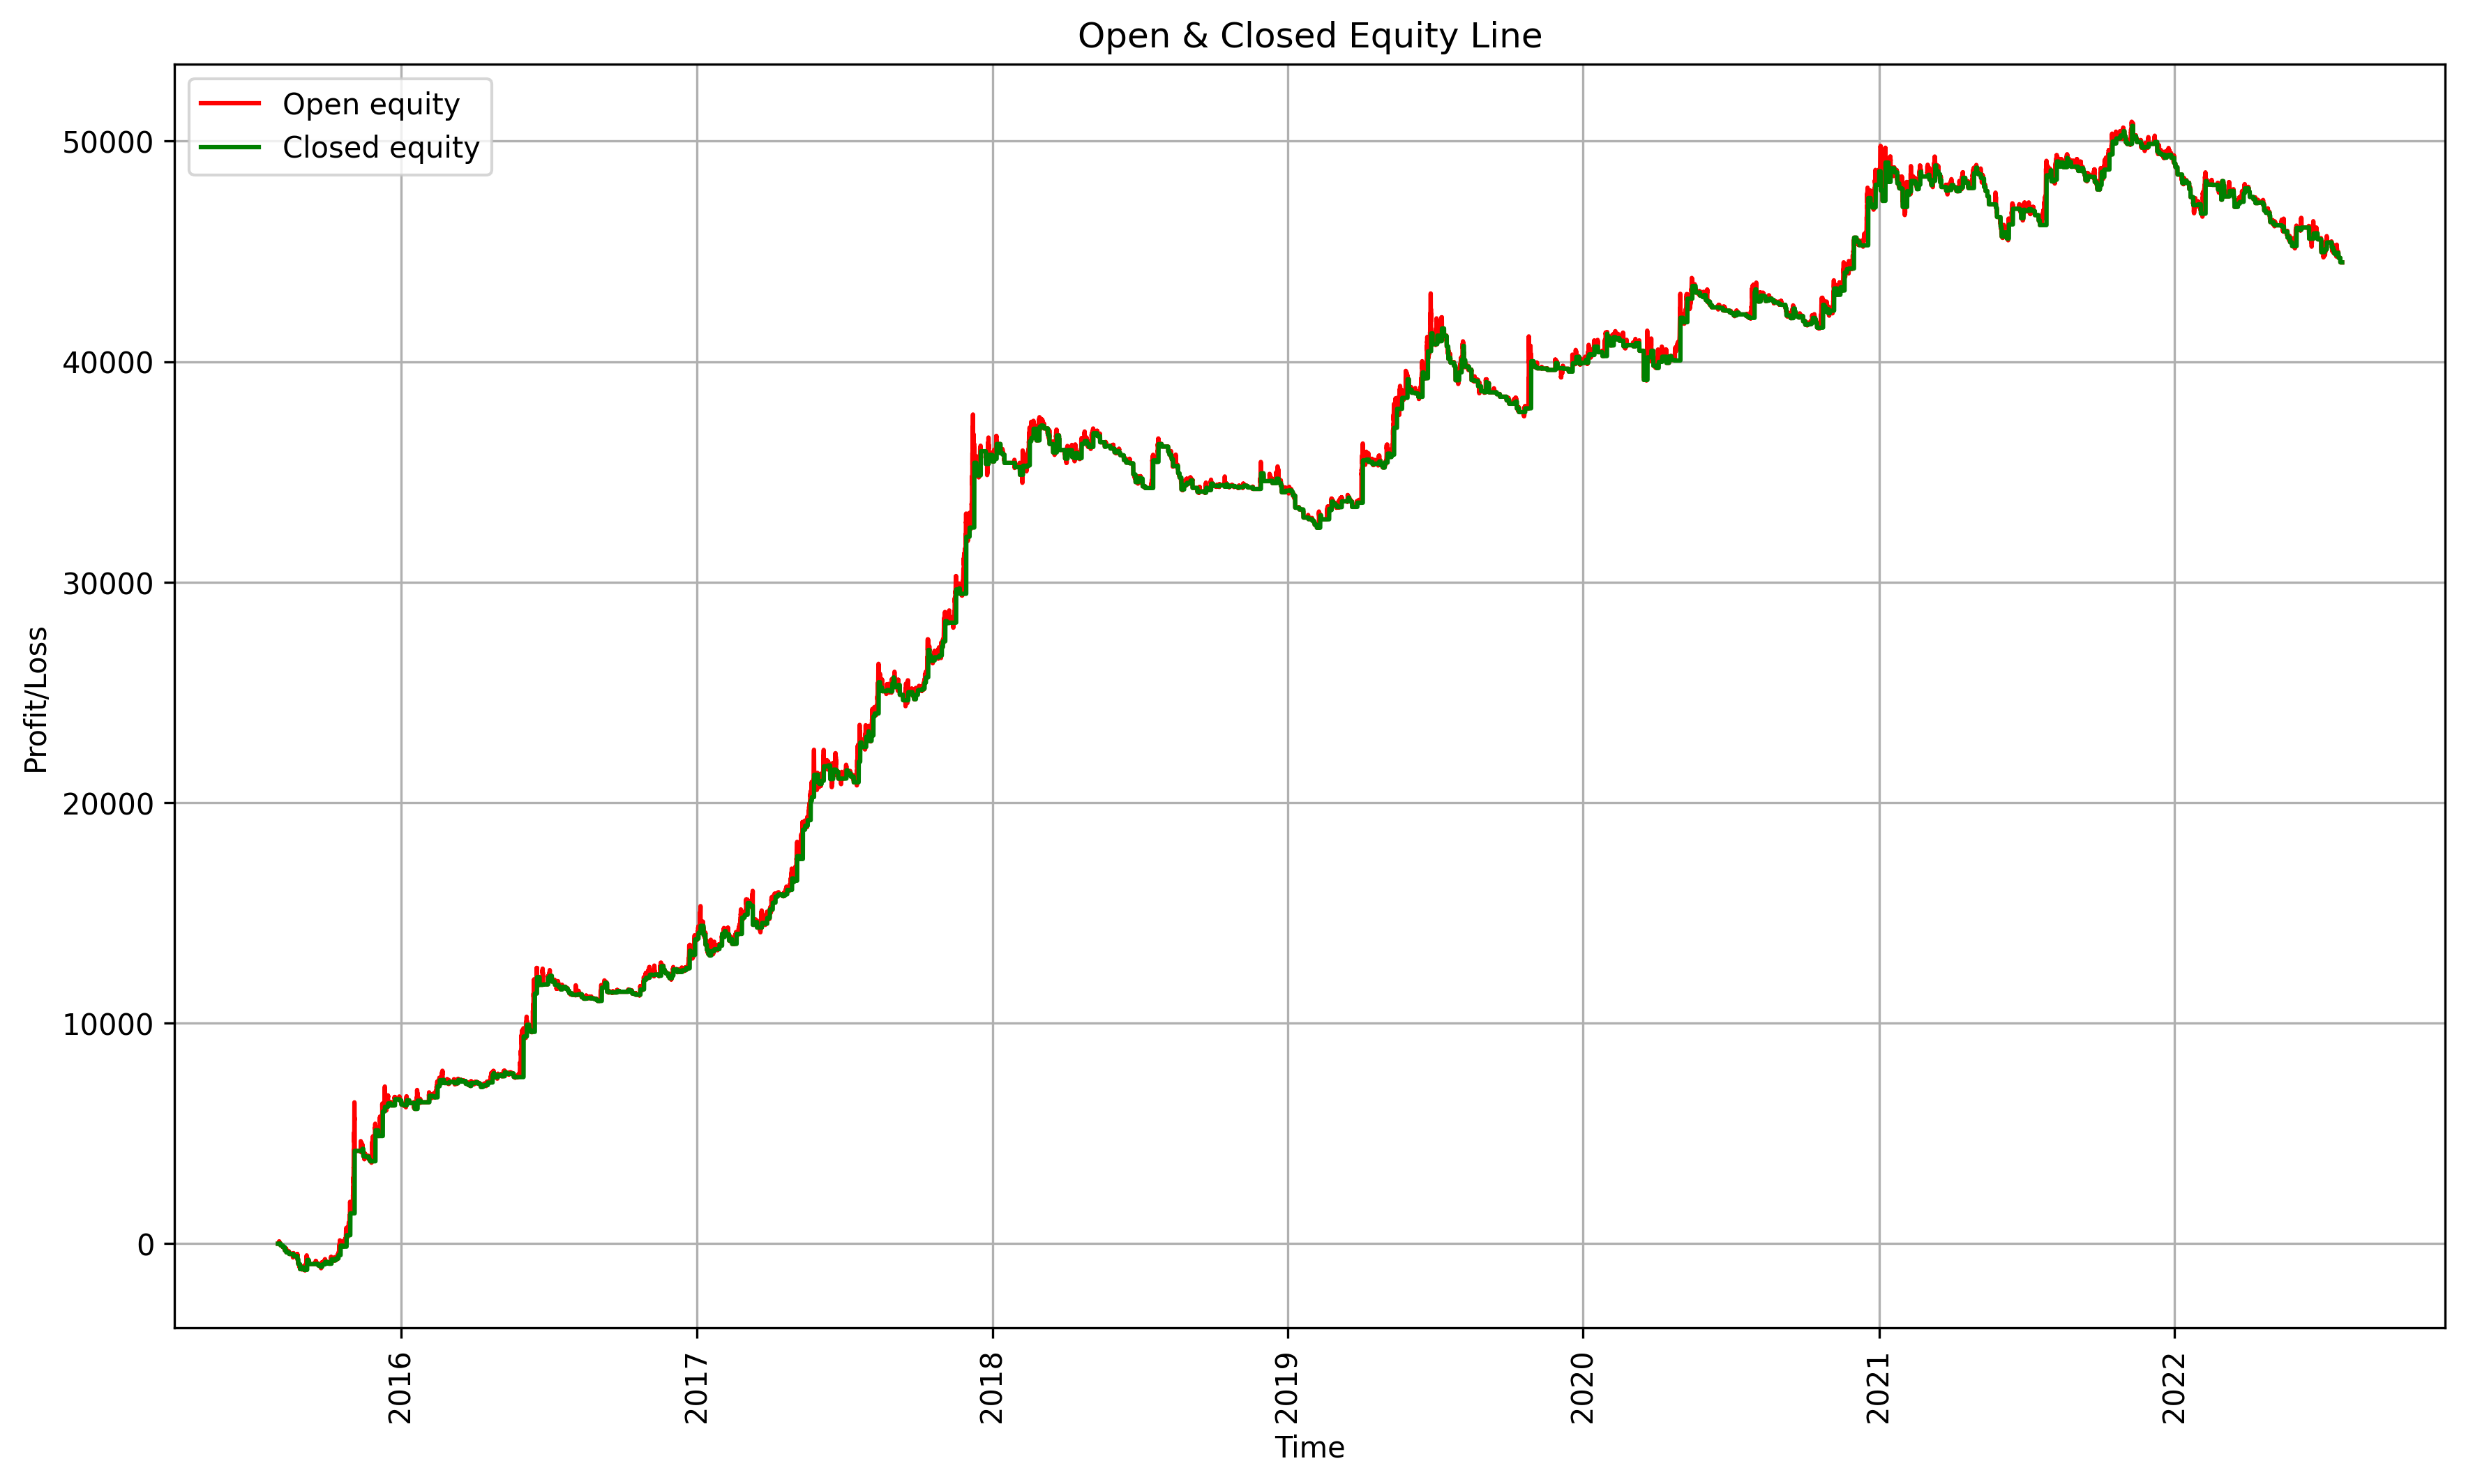

In [160]:
# Plot open e closed equity line
plot_double_equity(trading_system.closed_equity,trading_system.open_equity);

In [161]:
# Plot trading system (buys and sells)
def plot_trading_system(data):
    plt.figure(figsize=(14, 8), dpi=300)
    buy_price = data['plot_entry_price']
    sell_price = data['plot_sell_price']
    data['close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
    plt.scatter(data.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(data.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('BITCOIN Dochian channel STRATEGY TRADING SIGNALS')
    plt.legend(loc = 'upper left')
    plt.show()

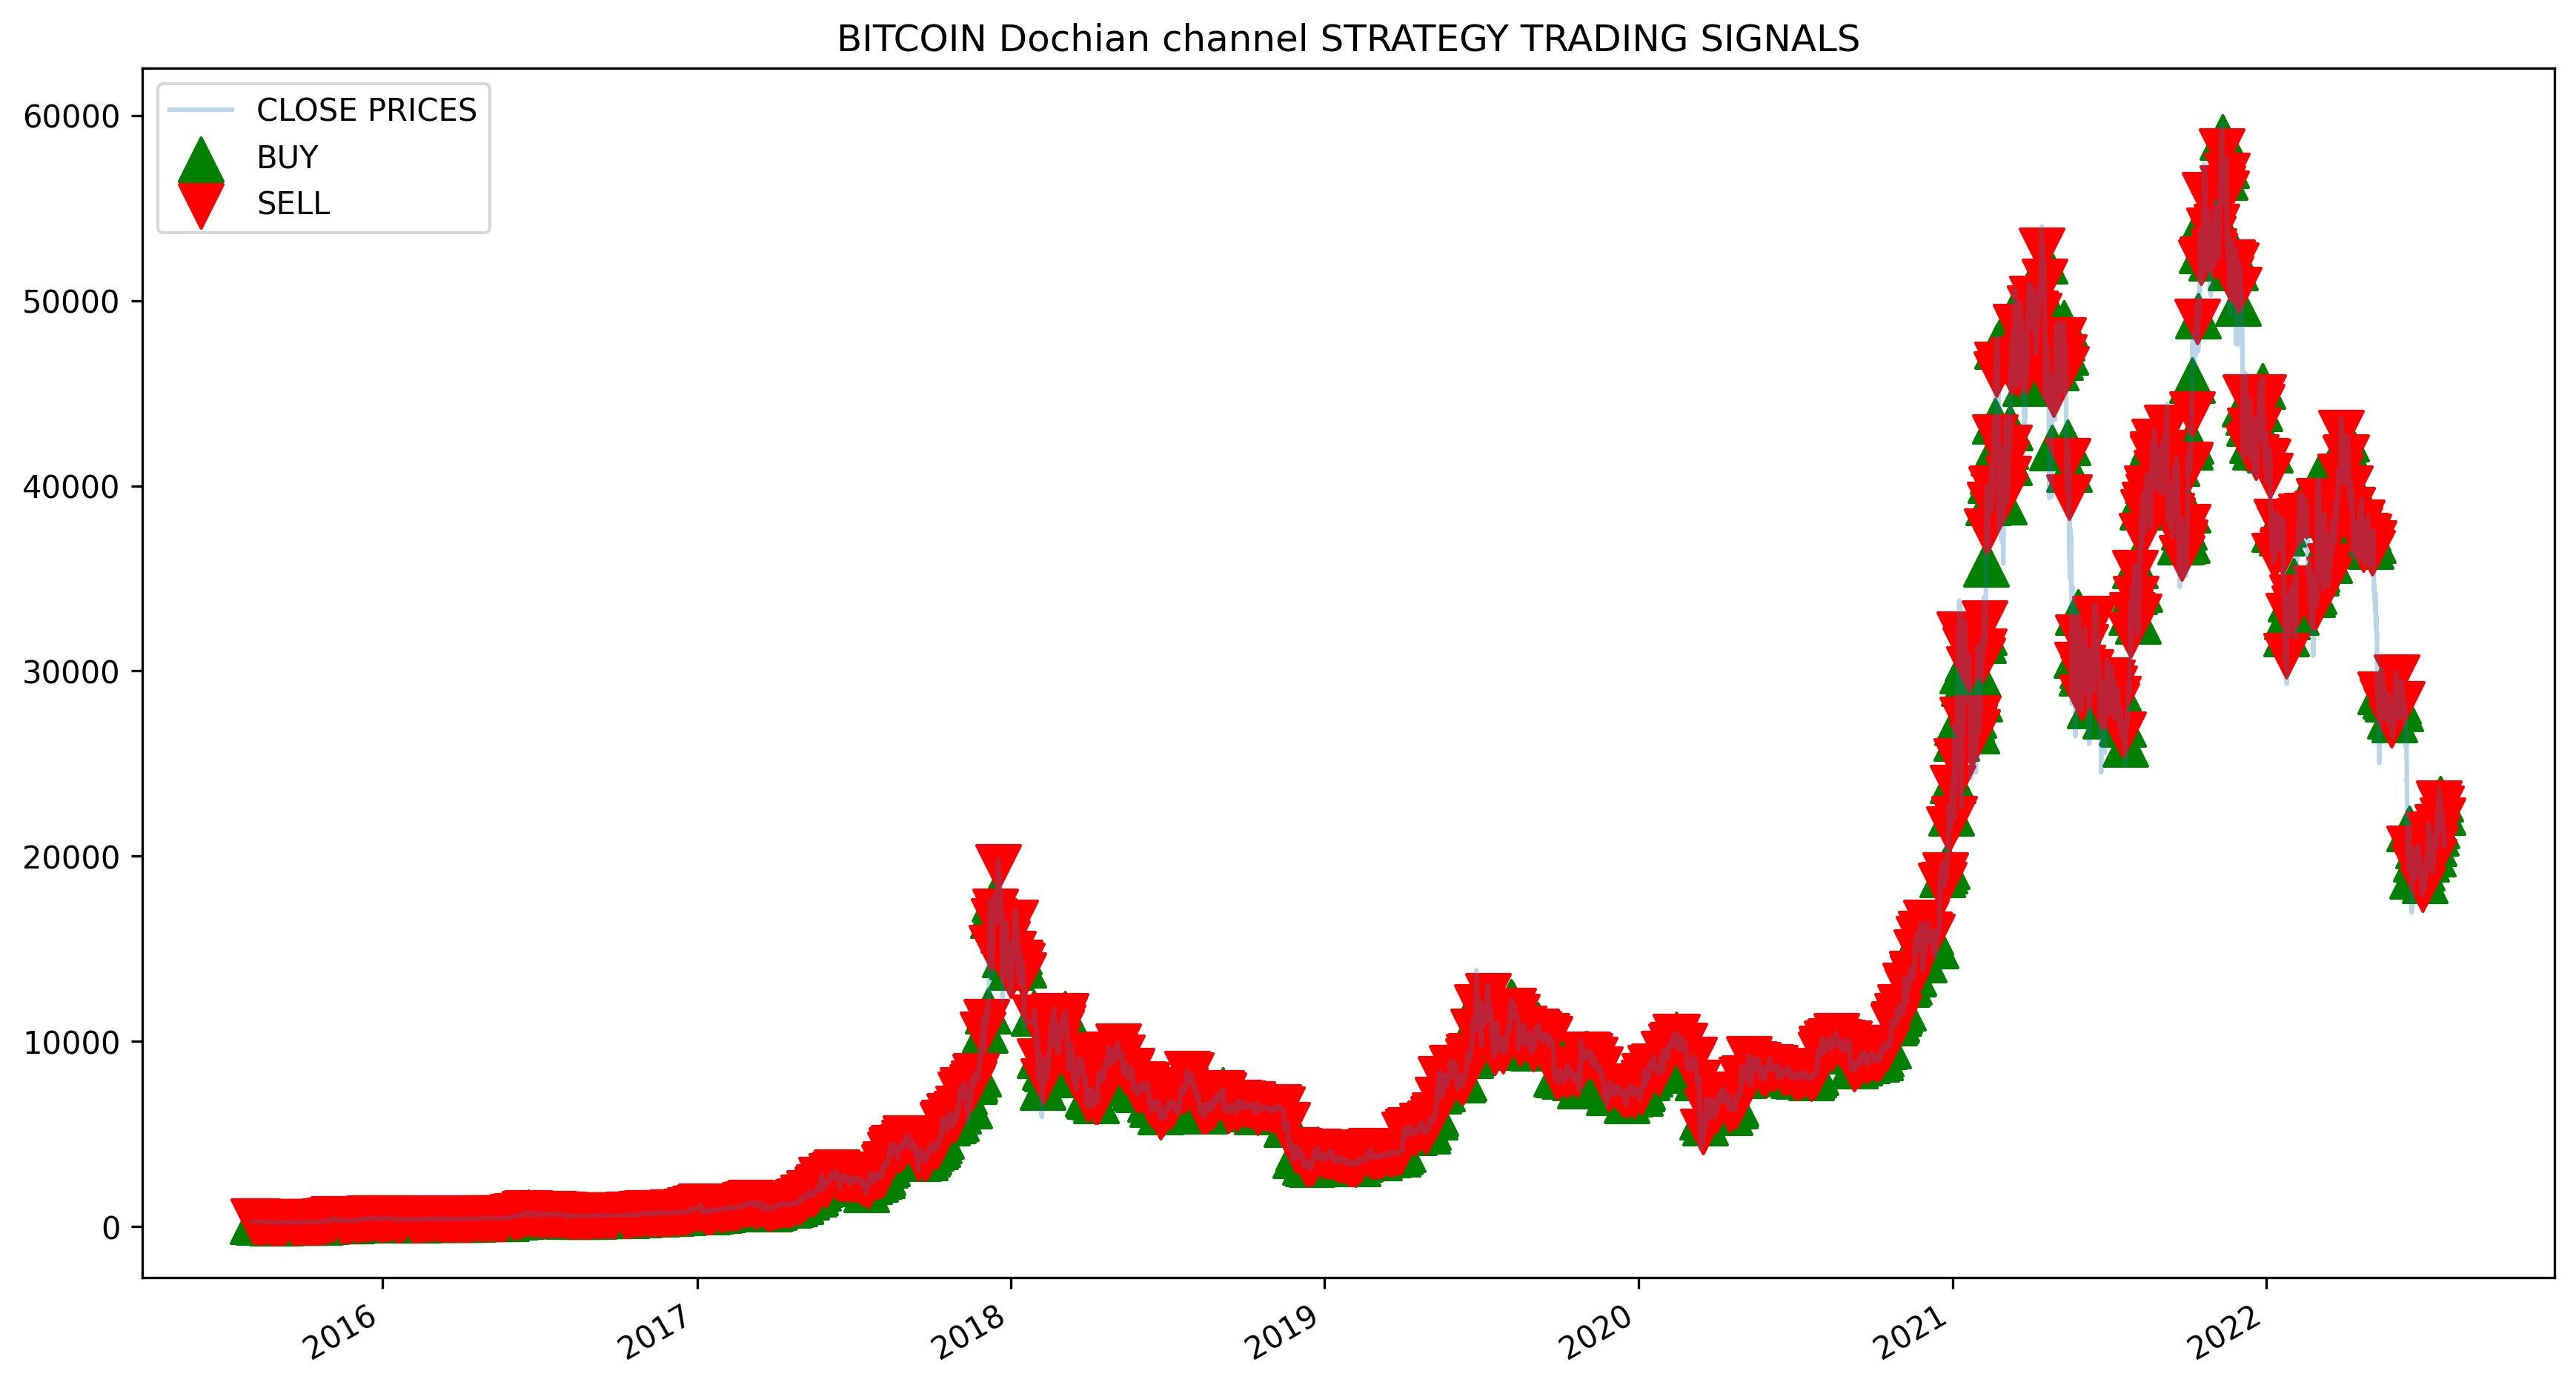

In [162]:
# plot trading system
plot_trading_system(trading_system) 

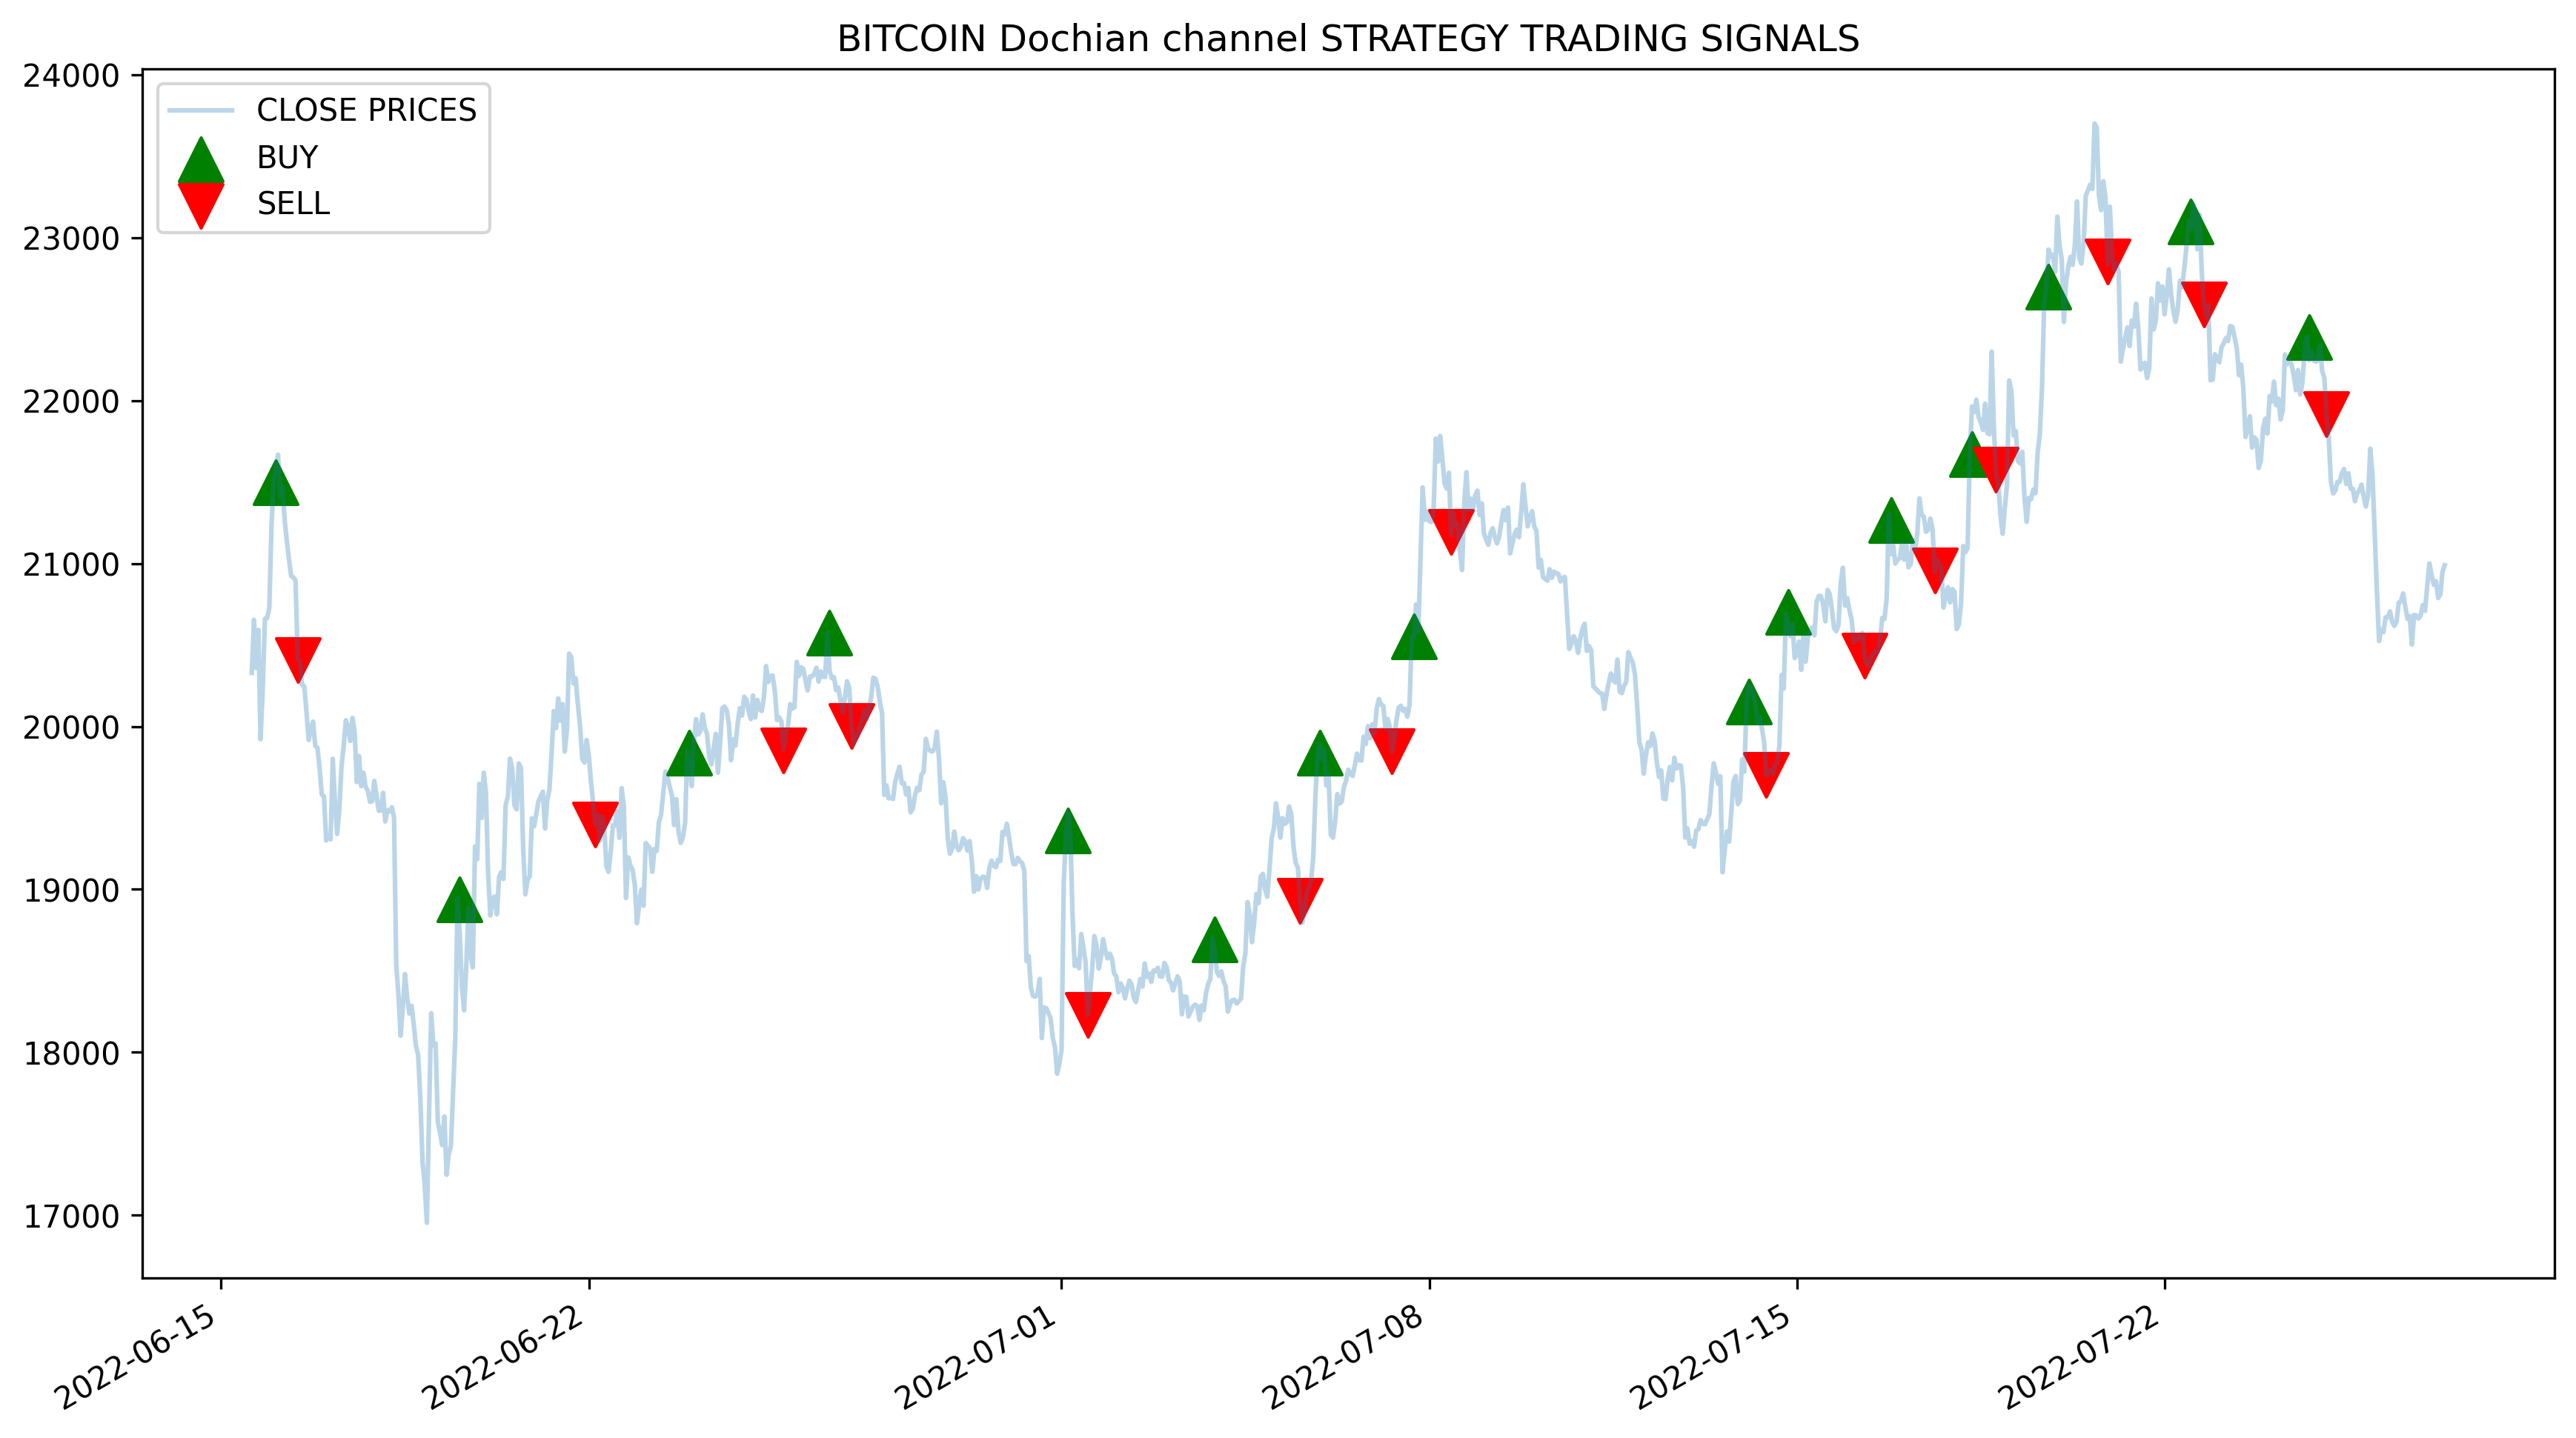

In [163]:
# plot trading system with subset dataset
plot_trading_system(trading_system.iloc[len(data)-1000:,:])